In [1]:
import os
import json
import numpy as np
from tensorflow import keras
from matplotlib import pyplot as plt
from PIL import Image
from typing import List, Tuple
from typing_extensions import TypedDict
from copy import deepcopy

In [2]:
IMAGE_SIZE = (512, 512)
TEST_RATIO = 0.2

In [3]:
class GeometricFigure(TypedDict):
    id: int
    category: str
    is_failed: bool
    filename: str
    image: np.ndarray


class GeometricFigureFromJSON(TypedDict):
    id: int
    type: str
    isFailed: bool
    filename: str

In [4]:
def load_image(path: str) -> np.ndarray:
    img = Image.open(path)
    img = img.resize(IMAGE_SIZE)
    img = np.array(img, dtype=float)/255
    return img


def get_filenames_from_directory(path: str) -> list:
    return [os.path.join(path, f) for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]


def get_geometric_figures(path: str) -> List[GeometricFigure]:
    with open(path, 'r') as f:
        content = f.read()
    data: List[GeometricFigureFromJSON] = json.loads(content)
    geometric_figures: List[GeometricFigure] = [{
        'id': d['id'],
        'category': d['type'],
        'is_failed': d['isFailed'],
        'filename': d['filename'],
        'image': load_image(os.path.join('data', 'Geometric Figures', d['filename']))
    } for d in data]
    return geometric_figures
    
geometric_figures: List[GeometricFigure] = get_geometric_figures('data/data.json')

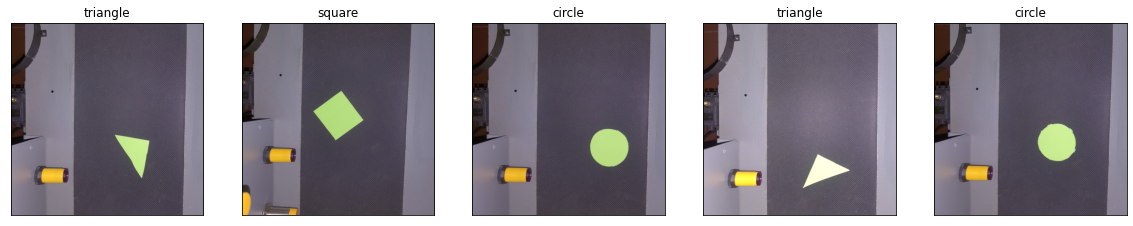

In [14]:
def plot_random_geometric_figures(geometric_figures: List[GeometricFigure], n: int) -> None:
    fig, axs = plt.subplots(1, n, figsize=(20, 20))
    for i in range(n):
        index = np.random.randint(0, len(geometric_figures))
        axs[i].imshow(geometric_figures[index]['image'])
        axs[i].set_title(geometric_figures[index]['category'])
        axs[i].set_xticks([])
        axs[i].set_yticks([])
    fig.patch.set_facecolor('white')

plot_random_geometric_figures(geometric_figures, 5)
plt.show()

Verificação dos canais de cor da imagem para identificar o canal de maior importância

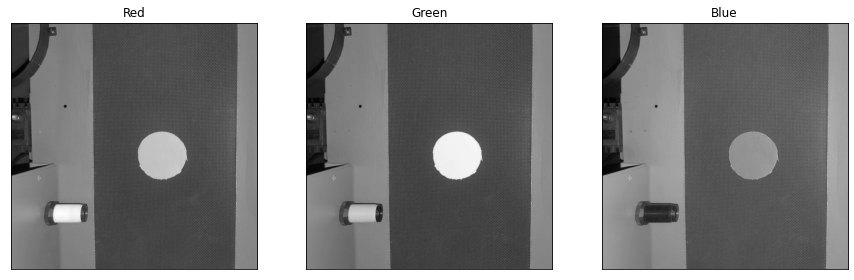

In [15]:
def plot_separate_color_channels_image(image: np.ndarray) -> None:
    fig, axs = plt.subplots(1, 3, figsize=(15, 15))
    axs[0].imshow(image[:, :, 0], cmap='gray')
    axs[0].set_title('Red')
    axs[0].set_xticks([])
    axs[0].set_yticks([])
    axs[1].imshow(image[:, :, 1], cmap='gray')
    axs[1].set_title('Green')
    axs[1].set_xticks([])
    axs[1].set_yticks([])
    axs[2].imshow(image[:, :, 2], cmap='gray')
    axs[2].set_title('Blue')
    axs[2].set_xticks([])
    axs[2].set_yticks([])
    fig.patch.set_facecolor('white')

image = geometric_figures[np.random.randint(0, len(geometric_figures))]['image']
plot_separate_color_channels_image(image)
plt.show()

In [16]:
model = keras.Sequential([
    keras.layers.Flatten(input_shape=IMAGE_SIZE),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(64, activation='relu'),
    keras.layers.Dense(32, activation='relu'),
    keras.layers.Dense(3, activation='softmax')
])
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_1 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)               33554560  
_________________________________________________________________
dense_5 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_7 (Dense)              (None, 3)                 99        
Total params: 33,564,995
Trainable params: 33,564,995
Non-trainable params: 0
_________________________________________________________________


In [17]:
def get_input_and_output(geometric_figure: List[GeometricFigure]) -> Tuple[np.ndarray, np.ndarray]:
    x = geometric_figure['image'][:, :, 1]
    y = {
        'circle': 0,
        'square': 1,
        'triangle': 2,
    }[geometric_figure['category']]
    return x, y


shuffled_geometric_figures: List[GeometricFigure] = deepcopy(geometric_figures)
np.random.shuffle(shuffled_geometric_figures)

x, y = zip(*[get_input_and_output(gf) for gf in shuffled_geometric_figures])
x = np.array(x)
y = np.array(y)

test_size = int(len(x) * TEST_RATIO)
x_train, x_test = x[:-test_size], x[-test_size:]
y_train, y_test = y[:-test_size], y[-test_size:]


In [22]:
model.fit(x_train, y_train, epochs=20)

Epoch 1/20
8/8 [==============================] - 1s 133ms/step - loss: 0.1874 - accuracy: 0.9208
Epoch 2/20
8/8 [==============================] - 1s 127ms/step - loss: 0.0736 - accuracy: 0.9875
Epoch 3/20
8/8 [==============================] - 1s 126ms/step - loss: 0.0596 - accuracy: 0.9667
Epoch 4/20
8/8 [==============================] - 1s 123ms/step - loss: 0.1112 - accuracy: 0.9625
Epoch 5/20
8/8 [==============================] - 1s 124ms/step - loss: 0.1379 - accuracy: 0.9542
Epoch 6/20
8/8 [==============================] - 1s 117ms/step - loss: 0.1106 - accuracy: 0.9667
Epoch 7/20
8/8 [==============================] - 1s 115ms/step - loss: 0.1206 - accuracy: 0.9500
Epoch 8/20
8/8 [==============================] - 1s 115ms/step - loss: 0.0901 - accuracy: 0.9708
Epoch 9/20
8/8 [==============================] - 1s 114ms/step - loss: 0.1008 - accuracy: 0.9667
Epoch 10/20
8/8 [==============================] - 1s 136ms/step - loss: 0.2217 - accuracy: 0.9292
Epoch 11/20
8/8 [==

In [23]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 21ms/step - loss: 0.0862 - accuracy: 0.9500


[0.08624906837940216, 0.949999988079071]

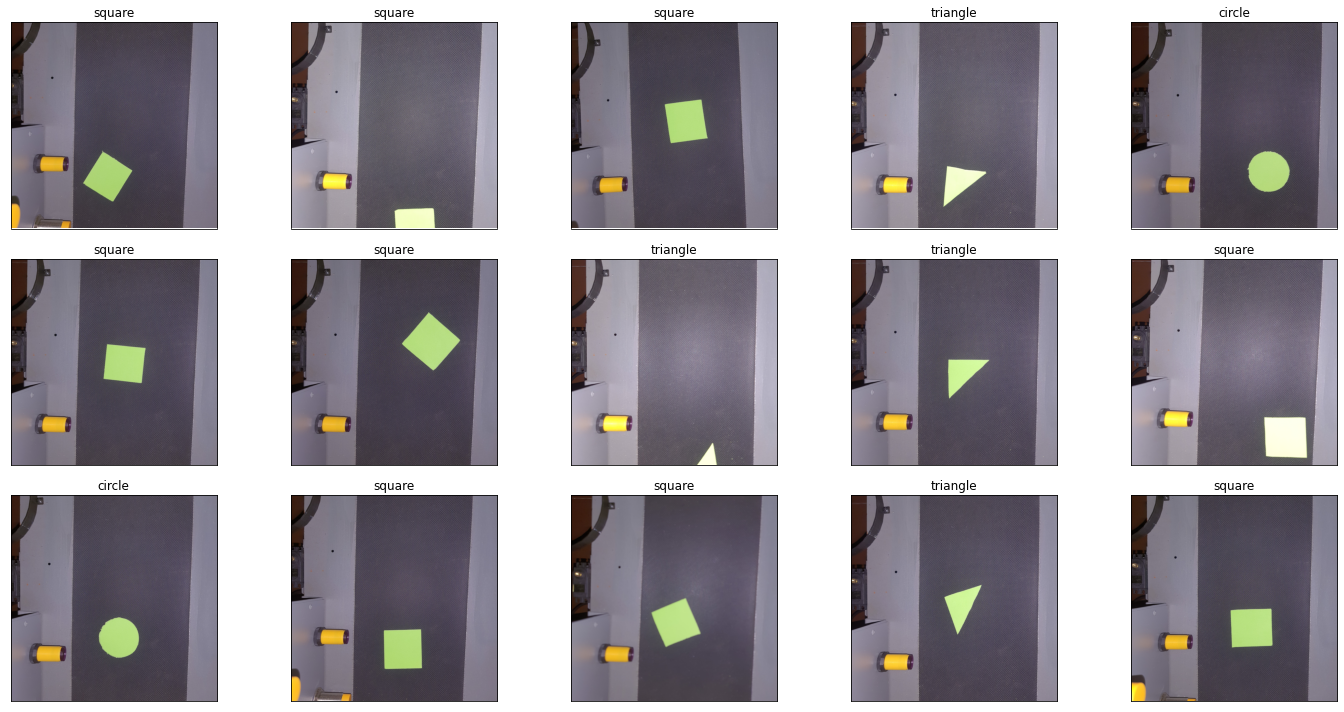

In [24]:
def predict_to_category(y_pred: np.ndarray) -> str:
    category_mapping = {
        0: 'circle',
        1: 'square',
        2: 'triangle',
    }
    return category_mapping[y_pred.argmax()]


rows = 3
columns = 5
random_figures = [geometric_figures[np.random.randint(0, len(geometric_figures))] for _ in range(columns * rows)]
fig, axs = plt.subplots(rows, columns, figsize=(20, 10))
for i in range(rows):
    for j in range(columns):
        random_figure = random_figures[i * columns + j]
        x, y = get_input_and_output(random_figure)
        x = np.expand_dims(x, axis=0)
        y_pred = model.predict(x)
        category = predict_to_category(y_pred)
        axs[i, j].imshow(random_figure['image'])
        axs[i, j].set_title(category)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

fig.patch.set_facecolor('white')
plt.tight_layout()
plt.show()

In [25]:
model.save('data/geometric_figure_classifier.h5')